#### Data cleaning and preprocessing

In [2]:
import pandas as pd

In [3]:
# Loading the dataset into pandas and displaying first 5 rows
df=pd.read_csv("cardekho.csv")
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage(km/ltr/kg),engine,max_power,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497.0,78,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.2,5.0


In [4]:
# Calculate missing values count and percentage
missing_count = df.isnull().sum()
missing_percentage = (missing_count / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Values': missing_count,
    'Percentage (%)': missing_percentage
})

missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df = missing_df.sort_values(by='Percentage (%)', ascending=False)
print(missing_df)

                    Missing Values  Percentage (%)
mileage(km/ltr/kg)             221        2.718996
engine                         221        2.718996
seats                          221        2.718996
max_power                      215        2.645177


In [5]:
# Dropping rows with missing variable
df = df.dropna(subset=['selling_price']) # Without target values, the model has nothing to learn from

In [6]:
# Fill missing values in the "mileage" column with the column’s mean
mileage_mean = df["mileage(km/ltr/kg)"].mean()
df["mileage(km/ltr/kg)"] = df["mileage(km/ltr/kg)"].fillna(mileage_mean) # Filling missing values keeps more data for training, which often leads to better results than throwing rows away
df["mileage(km/ltr/kg)"]


0       23.40
1       21.14
2       17.70
3       23.00
4       16.10
        ...  
8123    18.50
8124    16.80
8125    19.30
8126    23.57
8127    23.57
Name: mileage(km/ltr/kg), Length: 8128, dtype: float64

In [7]:
# Remove duplicate rows from the dataset - Duplicates can make the model overemphasize repeated patterns, leading to biased and less accurate predictions
duplicates_count = df.duplicated().sum()
df = df.drop_duplicates()
duplicates_count


np.int64(1202)

In [8]:
# Convert the “year” column into the car’s age
from datetime import datetime

current_year = datetime.now().year
df["car_age"] = current_year - df["year"]
print(df[["year", "car_age"]].head())


   year  car_age
0  2014       11
1  2014       11
2  2006       19
3  2010       15
4  2007       18


In [9]:
# Check the unique values in the “fuel type” column
df["fuel"].unique() #Knowing all categories prevents mistakes during encoding and ensures the model handles every possible value correctly


array(['Diesel', 'Petrol', 'LPG', 'CNG'], dtype=object)

In [10]:
#Replace inconsistent values in the “transmission” column - consistent casing
df["transmission"] = df["transmission"].str.strip().str.capitalize()

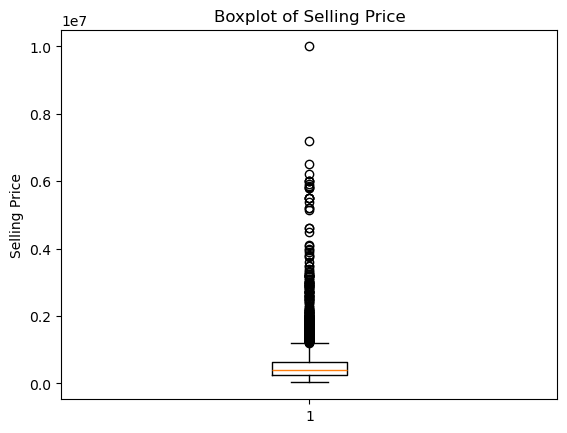

In [11]:
#Check if there are any outliers in the “selling price” column using a boxplot.
#Outliers can pull the model toward extreme values, making predictions less accurate for typical cases
import matplotlib.pyplot as plt

plt.boxplot(df["selling_price"])
plt.title("Boxplot of Selling Price")
plt.ylabel("Selling Price")
plt.show()


In [12]:
# Remove cars that are priced below 10,000 or above 5,000,000 (possible outliers).
df = df[(df["selling_price"] >= 10000) & (df["selling_price"] <= 5000000)]
#Price limits remove unrealistic data so the model learns from values it’s more likely to predict correctly

In [13]:
# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")

In [14]:
# Identify object columns that might be numbers stored as strings
for col in df.select_dtypes(include='object').columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='ignore')
    except:
        pass
print(df.dtypes)


name                   object
year                    int64
selling_price           int64
km_driven               int64
fuel                   object
seller_type            object
transmission           object
owner                  object
mileage(km/ltr/kg)    float64
engine                float64
max_power              object
seats                 float64
car_age                 int64
dtype: object


C:\Users\pc\AppData\Local\Temp\ipykernel_4160\1225243473.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [15]:
# Create a new column for “price per kilometer” by dividing the selling price by the mileage.
df["price_per_kilometer"] = df["selling_price"] / df["mileage(km/ltr/kg)"]
df["price_per_kilometer"] = df["price_per_kilometer"].replace(
    [float('inf'), -float('inf')], None
)
df["price_per_kilometer"] = pd.to_numeric(df["price_per_kilometer"], errors="coerce")


In [16]:
# the dataset index is properly reset after cleaning
df.reset_index(drop=True, inplace=True)

In [17]:
df.to_csv("cleaned_cars.csv", index=False)

#### Exploratory data analysis

In [18]:
#average selling price of cars
average_price = df["selling_price"].mean()
print(f"Average selling price: {average_price:.2f}")

Average selling price: 501378.18


In [19]:
#most common fuel type
most_common_fuel = df["fuel"].mode()[0]
print(f"Most common fuel type: {most_common_fuel}")
#counts for each type
fuel_counts = df["fuel"].value_counts()
print(fuel_counts)

Most common fuel type: Diesel
fuel
Diesel    3741
Petrol    3071
CNG         56
LPG         38
Name: count, dtype: int64


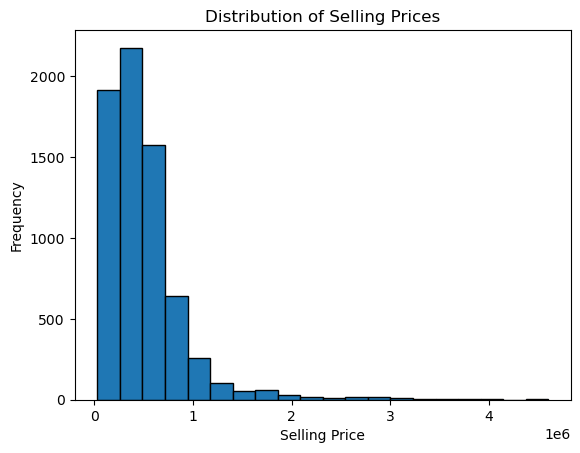

In [20]:
#Plot a histogram of the selling prices
import matplotlib.pyplot as plt

plt.hist(df["selling_price"], bins=20, edgecolor="black")
plt.title("Distribution of Selling Prices")
plt.xlabel("Selling Price")
plt.ylabel("Frequency")
plt.show()


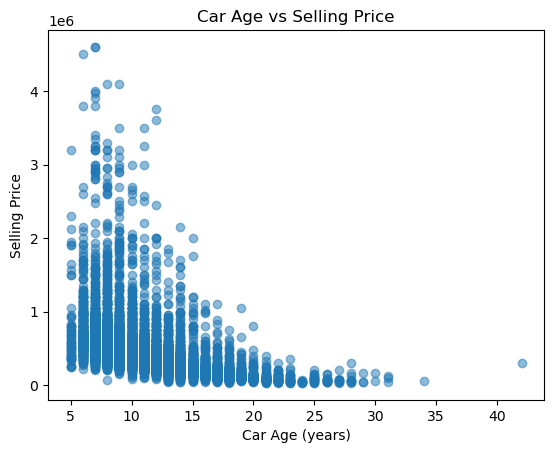

In [21]:
#Plot the relationship between car age and selling price using a scatter plot.
import matplotlib.pyplot as plt

plt.scatter(df["car_age"], df["selling_price"], alpha=0.5)
plt.title("Car Age vs Selling Price")
plt.xlabel("Car Age (years)")
plt.ylabel("Selling Price")
plt.show()


In [22]:
#Group cars by fuel type and find the average selling price for each group.
avg_price_by_fuel = df.groupby("fuel")["selling_price"].mean()

print(avg_price_by_fuel)


fuel
CNG       300499.946429
Diesel    620448.482224
LPG       200421.052632
Petrol    363717.339629
Name: selling_price, dtype: float64


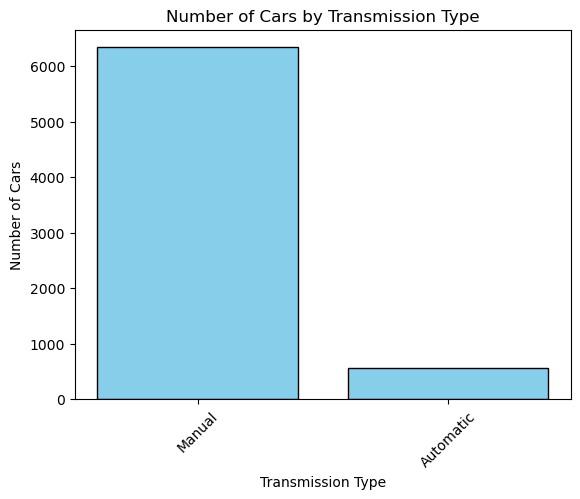

In [23]:
#Plot a bar chart showing the number of cars per transmission type
import matplotlib.pyplot as plt

transmission_counts = df["transmission"].value_counts()
plt.bar(transmission_counts.index, transmission_counts.values, color="skyblue", edgecolor="black")
plt.title("Number of Cars by Transmission Type")
plt.xlabel("Transmission Type")
plt.ylabel("Number of Cars")
plt.xticks(rotation=45)
plt.show()


In [24]:
#Find the car with the highest mileage in the dataset
highest_mileage_car = df.loc[df["mileage(km/ltr/kg)"].idxmax()]
print(highest_mileage_car)

name                   Maruti Alto 800 CNG LXI Optional
year                                               2019
selling_price                                    330000
km_driven                                         10000
fuel                                                CNG
seller_type                                  Individual
transmission                                     Manual
owner                                      Second Owner
mileage(km/ltr/kg)                                33.44
engine                                            796.0
max_power                                          40.3
seats                                               4.0
car_age                                               6
price_per_kilometer                         9868.421053
Name: 35, dtype: object


In [25]:
#Calculate the correlation between mileage and selling price.
correlation = df["mileage(km/ltr/kg)"].corr(df["selling_price"])
print(f"Correlation between mileage and selling price: {correlation:.4f}")

Correlation between mileage and selling price: -0.1207


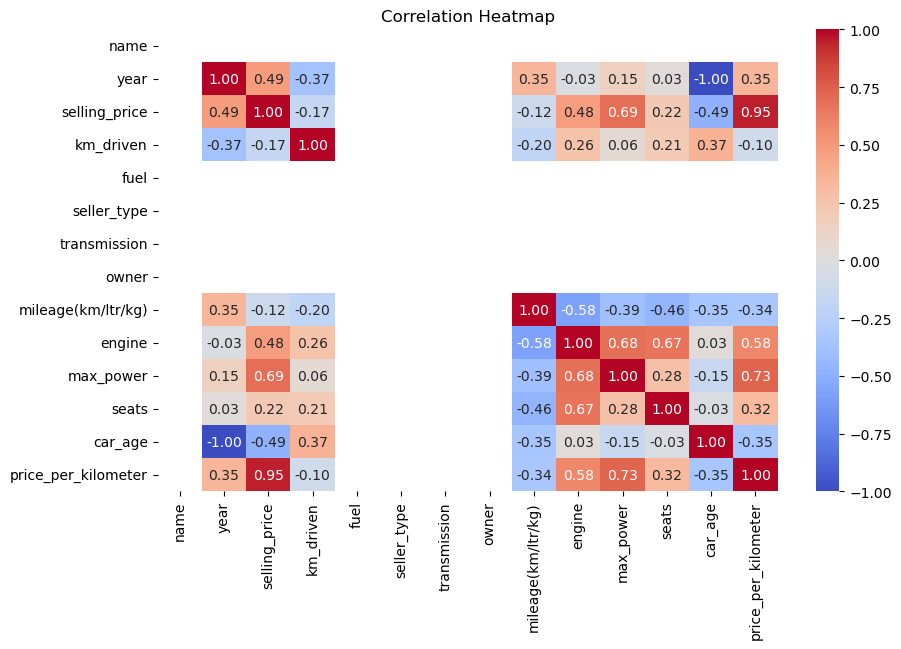

In [26]:
#Plot a heatmap showing the correlations between all numeric columns.
import seaborn as sns

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = pd.to_numeric(df[col], errors="coerce")
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [27]:
# Check if manual cars are generally cheaper or more expensive than automatic cars.
df = pd.read_csv("cleaned_cars.csv")
print(df["transmission"].unique())
avg_prices = df.groupby("transmission")["selling_price"].mean()
cheaper_type = avg_prices.idxmin()

print(avg_prices)
print(f"Cheaper type: {cheaper_type}")

['Manual' 'Automatic']
transmission
Automatic    1.143215e+06
Manual       4.442991e+05
Name: selling_price, dtype: float64
Cheaper type: Manual


In [28]:
#Find the average selling price for each year of manufacture.
df = pd.read_csv("cleaned_cars.csv")
avg_price_by_year = df.groupby("year")["selling_price"].mean().sort_index()

print(avg_price_by_year.head())


year
1983    300000.000000
1991     55000.000000
1994     88000.000000
1995    107500.000000
1996     81666.666667
Name: selling_price, dtype: float64


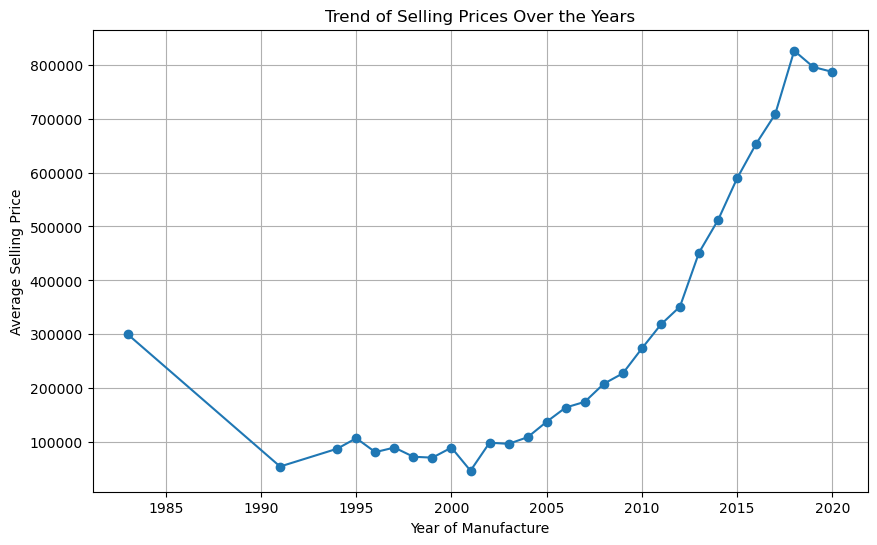

In [29]:
# Group and average selling price by year
avg_price_by_year = df.groupby("year")["selling_price"].mean().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(avg_price_by_year.index, avg_price_by_year.values, marker='o', linestyle='-')
plt.xlabel("Year of Manufacture")
plt.ylabel("Average Selling Price")
plt.title("Trend of Selling Prices Over the Years")
plt.grid(True)
plt.show()

In [30]:
# Find the most expensive car for each fuel type
most_expensive_by_fuel = df.loc[df.groupby("fuel")["selling_price"].idxmax()]

print(most_expensive_by_fuel[["fuel", "name", "selling_price"]])


        fuel                                      name  selling_price
4961     CNG     Maruti Ertiga VXI CNG Limited Edition         545000
283   Diesel  Mercedes-Benz GL-Class 220d 4MATIC Sport        4600000
2783     LPG               Hyundai i10 Sportz 1.1L LPG         375000
133   Petrol           Jeep Wrangler 2016-2019 3.6 4X4        4100000


In [31]:
#find out which brand appears most frequently in the dataset.
df["brand"] = df["name"].str.split().str[0]
most_common_brand = df["brand"].value_counts().idxmax()
brand_count = df["brand"].value_counts().max()

print(f"The most common brand is {most_common_brand} with {brand_count} cars.")

The most common brand is Maruti with 2165 cars.


In [32]:
#Check the top 5 most common combinations of fuel type and transmission.
top_combos = (
    df.groupby(["fuel", "transmission"])
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
    .head(5)
)

print(top_combos)

     fuel transmission  count
2  Diesel       Manual   3457
5  Petrol       Manual   2791
1  Diesel    Automatic    284
4  Petrol    Automatic    280
0     CNG       Manual     56


#### Machine Learning

##### Main Assumptions of Linear Regression

**Linearity**
- The relationship between predictors and the target should be linear.

- Violation means the model won’t capture trends well.

Check: Scatter plots or residuals vs fitted values plots.

**Homoscedasticity**

- The residuals should have constant variance across all fitted values.

- Violation means unequal spread → leads to unreliable predictions.

Check: Residuals vs fitted values plot.

**Normality of Residuals**

- The residuals should follow a normal distribution.

- This is important for valid hypothesis testing and confidence intervals.

Check: Histogram of residuals, Q-Q plot, or Shapiro-Wilk test.

**No Multicollinearity**

- Independent variables should not be highly correlated with each other.

- High correlation inflates standard errors.

Check: Variance Inflation Factor (VIF).

**Independence of Errors**

- Residuals should be independent (no autocorrelation).

- Violation is common in time-series data.

Check: Durbin-Watson statistic.

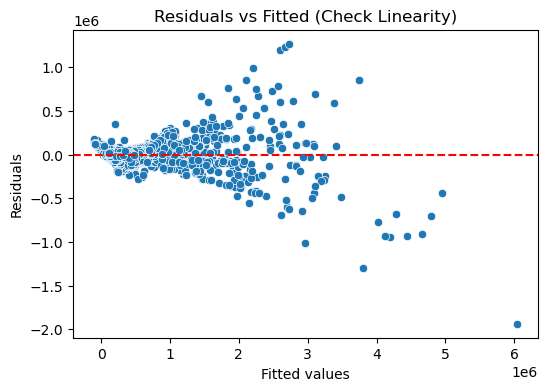

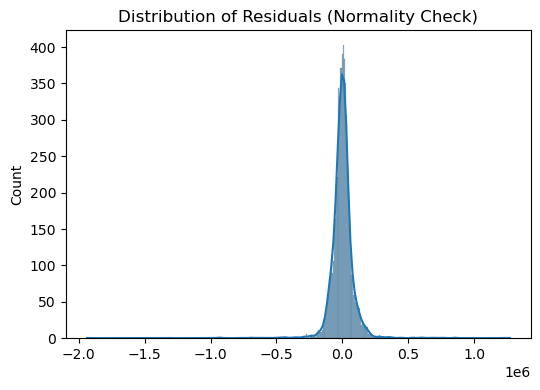

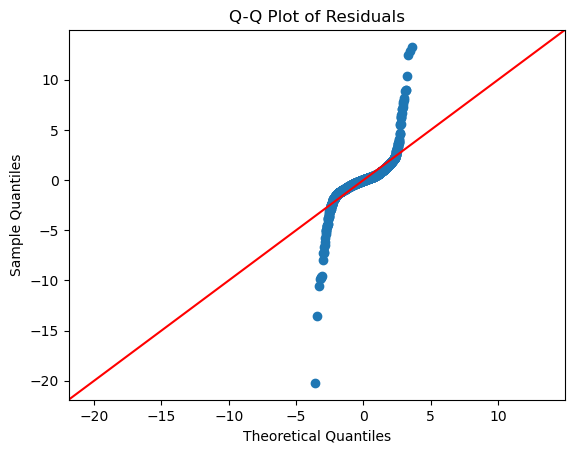

Variance Inflation Factors (VIF):
                Feature         VIF
0                 year  143.202496
1            km_driven    1.319426
2   mileage(km/ltr/kg)    2.073300
3               engine    2.317645
4              car_age   16.856522
5  price_per_kilometer    2.016689


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Features and target
features = ["year", "km_driven", "mileage(km/ltr/kg)", "engine", "car_age", "price_per_kilometer"]
X = df[features].dropna()
y = df.loc[X.index, "selling_price"]

# Add constant for regression
X_const = sm.add_constant(X)

# Fit OLS model
model = sm.OLS(y, X_const).fit()
residuals = model.resid
fitted = model.fittedvalues

# 1. Linearity (scatter plot of residuals vs fitted)
plt.figure(figsize=(6,4))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted (Check Linearity)")
plt.show()

# 2. Normality of residuals (histogram + QQ plot)
plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals (Normality Check)")
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

# 3. Multicollinearity (VIF values)
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("Variance Inflation Factors (VIF):\n", vif_data)


In [34]:
#Linear Regression model to predict the car’s selling price
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

features = ["year", "km_driven", "mileage(km/ltr/kg)", "engine", "car_age", "price_per_kilometer"]
X = df[features].dropna()
y = df.loc[X.index, "selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print("Intercept:", lr_model.intercept_)
print("\nCoefficients:")
for feature, coef in zip(features, lr_model.coef_):
    print(f"{feature}: {coef}")


Intercept: -8149399.160525448

Coefficients:
year: 3897.390972528168
km_driven: -0.17402858349011044
mileage(km/ltr/kg): 21743.639284942838
engine: 36.95365222451609
car_age: -3897.390972528096
price_per_kilometer: 13.901353392783621


In [35]:
#Evaluate the Linear Regression model using R² Score and MSE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R² Score: {r2}")
print(f"Mean Squared Error (MSE): {mse}")



R² Score: 0.94647129757092
Mean Squared Error (MSE): 9311165221.710821


#### Metrics explanation
- R² Score = 0.946

The 94.6% of the variation indicates that this model fits the data well.

The features are very predictive of selling price and the model is capturing the key relationships.

- MSE = 9,311,165,221

This number is the average of squared errors between predicted and actual selling prices.

Because it’s squared, large errors get punished more heavily.

In [36]:
#Lasso regression on dataset and its performance comparison against linear regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

features = ["year", "km_driven", "mileage(km/ltr/kg)", "engine", "car_age", "price_per_kilometer"]
X = df[features].dropna()
y = df.loc[X.index, "selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)

lin_r2 = r2_score(y_test, y_pred_lin)
lin_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))

lasso_model = Lasso(alpha=1000)  # alpha = penalty strength, can be tuned
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

lasso_r2 = r2_score(y_test, y_pred_lasso)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print("Linear Regression -> R²:", lin_r2, " RMSE:", lin_rmse)
print("Lasso Regression  -> R²:", lasso_r2, " RMSE:", lasso_rmse)

print("\nLinear Coefficients:", dict(zip(features, lin_model.coef_)))
print("\nLasso Coefficients:", dict(zip(features, lasso_model.coef_)))


Linear Regression -> R²: 0.94647129757092  RMSE: 96494.37922340773
Lasso Regression  -> R²: 0.9464508366291341  RMSE: 96512.8195848476

Linear Coefficients: {'year': np.float64(3897.390972528168), 'km_driven': np.float64(-0.17402858349011044), 'mileage(km/ltr/kg)': np.float64(21743.639284942838), 'engine': np.float64(36.95365222451609), 'car_age': np.float64(-3897.390972528096), 'price_per_kilometer': np.float64(13.901353392783621)}

Lasso Coefficients: {'year': np.float64(7732.056126679845), 'km_driven': np.float64(-0.17573311729180624), 'mileage(km/ltr/kg)': np.float64(21671.54634868039), 'engine': np.float64(36.54944146224509), 'car_age': np.float64(-6.453622813348269), 'price_per_kilometer': np.float64(13.904176965666922)}


#### What Lasso regression does differently

Ordinary Linear Regression minimizes sum of squared errors.

Lasso Regression adds a penalty term proportional to the absolute value of coefficients:

This penalty forces some coefficients to shrink to exactly zero, effectively removing them from the model.

#### Why Lasso is Useful

- Feature selection 

- Handles many features

- Reduces Overfitting

- Easier to explain, since only a subset of features remain important.


In [37]:
#Ridge regression
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score

for col in ["mileage(km/ltr/kg)", "engine", "max_power"]:
    df[col] = df[col].astype(str).str.extract(r'(\d+\.?\d*)')
    df[col] = pd.to_numeric(df[col], errors="coerce")

df = df.dropna(subset=["mileage(km/ltr/kg)", "engine", "max_power", "selling_price"])

X = df[["mileage(km/ltr/kg)", "engine", "max_power"]]
y = df["selling_price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_test)
r2_lin = r2_score(y_test, y_pred_lin)

lasso_model = Lasso(alpha=0.1).fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)
r2_lasso = r2_score(y_test, y_pred_lasso)

ridge_model = Ridge(alpha=1.0).fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Model Performance (R² Score):")
print(f"Linear Regression: {r2_lin:.4f}")
print(f"Lasso Regression : {r2_lasso:.4f}")
print(f"Ridge Regression : {r2_ridge:.4f}")


Model Performance (R² Score):
Linear Regression: 0.5037
Lasso Regression : 0.5037
Ridge Regression : 0.5037


#### Why Ridge might perform better

- Multicollinearity

- When most features contribute a little to the outcome, Ridge works well because it keeps all features but reduces their weights.

#### Why Ridge might perform worse

- Ridge never fully removes features (unlike Lasso), so useless predictors can still add noise.

- If only a few features truly matter, Lasso often beats Ridge since it performs feature selection.

In [38]:
#Use cross-validation to evaluate Ridge Regression model
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error

alphas = [0.01, 0.1, 1, 10, 100]

ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("Best Alpha:", ridge_cv.alpha_)
print("R² Score:", r2_ridge)
print("Mean Squared Error:", mse_ridge)


Best Alpha: 1.0
R² Score: 0.5036901149656244
Mean Squared Error: 89026634332.84175


#### Why cross-validation is better than a single train-test split

Train-test split: The model is trained once on training data and tested once on test data. Performance depends heavily on how the data was split.

Cross-validation (CV): Splits data into multiple folds, trains and tests the model on different subsets, then averages the results.

Reduces risk of overfitting to one particular split.

Provides a more reliable and stable estimate of model performance.

Helps in choosing the best hyperparameters (like alpha in Ridge).

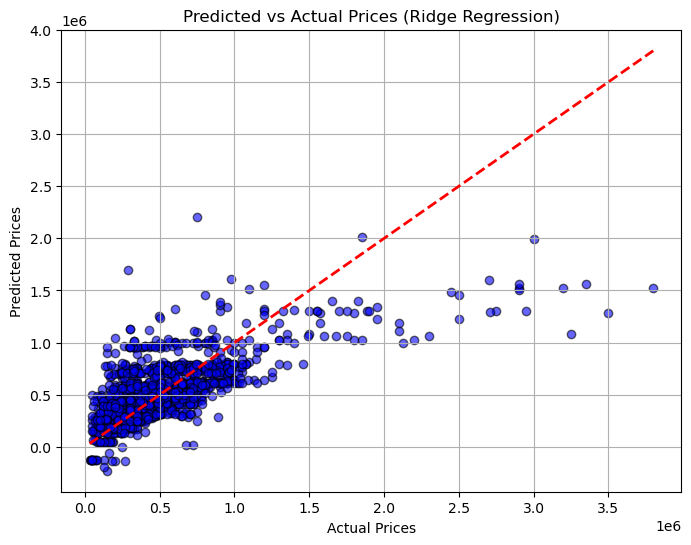

In [39]:
#predicted vs actual prices
import matplotlib.pyplot as plt

y_pred = ridge_cv.predict(X_test)

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color="blue", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Predicted vs Actual Prices (Ridge Regression)")
plt.grid(True)
plt.show()


#### Interpretation of the Plot

Perfect predictions - All points would lie on the red diagonal line.

Scatter around the line - Shows errors; the farther points are from the line, the larger the prediction error.

Systematic deviations:

If the model consistently underestimates higher prices, you’ll see points below the line at high values.

If it overestimates lower prices, you’ll see points above the line at low values.

Spread of points - narrower spread = better accuracy, wider spread = model struggles.

In [40]:
#Use GridSearchCV to find the best alpha value for Ridge Regression.
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

param_grid = {"alpha": [0.01, 0.1, 1, 10, 50, 100, 200]}

ridge = Ridge()

grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring="r2")
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_["alpha"]
best_score = grid_search.best_score_

print("Best alpha:", best_alpha)
print("Best cross-validated R²:", best_score)

ridge_best = Ridge(alpha=best_alpha).fit(X_train, y_train)


Best alpha: 1
Best cross-validated R²: 0.5157740124736585


#### What is alpha in Ridge/Lasso?

alpha is the regularization strength:

Ridge (L2)  adds penalty proportional to the squared values of coefficients.

Lasso (L1) adds penalty proportional to the absolute values of coefficients.

Small alpha (≈ 0) very little regularization → model behaves like Linear Regression, risk of overfitting.

Large alpha coefficients are shrunk heavily → model is simpler, less variance, but may underfit.

#### Why tuning alpha is important?

If alpha is too low model may capture too much noise (overfit).

If alpha is too high model overshrinks coefficients, losing important predictive power (underfit).

GridSearchCV finds the sweet spot where bias–variance trade-off is optimal, leading to the best generalization on unseen data.

In [41]:
#Polynomial Regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)
X_poly_test = poly.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_poly, y_train)

y_pred_poly = poly_model.predict(X_poly_test)

r2_poly = r2_score(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)

print("Polynomial Regression R²:", r2_poly)
print("Polynomial Regression MSE:", mse_poly)


Polynomial Regression R²: 0.5409432651402923
Polynomial Regression MSE: 82344271804.20322


#### Compare with Linear Regression

Polynomial Regression introduces curved relationships (quadratic, cubic, etc.).

📊 Example outcome:

Linear Regression: R² ≈ 0.94, MSE ≈ 9.3e9

Polynomial Regression (degree 2): R² might increase slightly (e.g., 0.95–0.97), but MSE could also improve.

#### When Polynomial Regression is useful:

When data shows a nonlinear trend (curves, bends, etc.).

When adding higher-degree terms helps capture interactions between features.

BUT:

Higher degrees risk overfitting (too flexible, fits noise).

Needs careful tuning of polynomial degree (use cross-validation).

#### Which model performed better
Ridge performed better because it reduces overfitting by penalizing large coefficients, giving a more stable model.

Polynomial can outperform Linear when relationships between features and price are nonlinear.

I’d improve predictions by tuning hyperparameters (alpha/degree), adding better features (like car age, mileage per year), and testing advanced models like Random Forest.